# 🚦 Детекция светофоров


Работа по первому сценарию проекта 


### Albumentations + Adam + FasterRCNN



#####  Датасет:
[**LISA Traffic Light Dataset**](https://www.kaggle.com/mbornoe/lisa-traffic-light-dataset)  

TG: @aurora124


## 1. Импорт бибилиотек и данных

In [1]:
import warnings
warnings.filterwarnings("ignore")
import datetime
from time import time
import pandas as pd
import os
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

import cv2

from sklearn.model_selection import train_test_split, GroupKFold, StratifiedKFold

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import nms

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
 
SEED = 42

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(SEED)

In [ ]:
DATA_PATH = '../input/lisa-traffic-light-dataset'
os.listdir(DATA_PATH)

['Annotations',
 'nightSequence2',
 'sample-dayClip6',
 'sample-nightClip1',
 'dayTrain',
 'nightTrain',
 'nightSequence1',
 'daySequence2',
 'daySequence1']

In [ ]:
DAY_TRAIN_PATH = '../input/lisa-traffic-light-dataset/Annotations/Annotations/dayTrain/'
NIGHT_TRAIN_PATH = '../input/lisa-traffic-light-dataset/Annotations/Annotations/nightTrain/'

### 2. Создание общего датасета с аннотациями

In [ ]:
train_day = []
for clipName in tqdm(sorted(os.listdir(DAY_TRAIN_PATH))):
    if 'dayClip' not in clipName:
        continue
    df = pd.read_csv(os.path.join(DAY_TRAIN_PATH,clipName,'frameAnnotationsBOX.csv'),sep=';')
    train_day.append(df)
    
train_day_df = pd.concat(train_day,axis=0)
train_day_df['isNight'] = 0
    
train_night = []
for clipName in tqdm(sorted(os.listdir(NIGHT_TRAIN_PATH))):
    if 'nightClip' not in clipName:
        continue
    df = pd.read_csv(os.path.join(NIGHT_TRAIN_PATH,clipName,'frameAnnotationsBOX.csv'),sep=';')
    train_night.append(df)

train_night_df = pd.concat(train_night,axis=0)
train_night_df['isNight'] = 1

df = pd.concat([train_day_df,train_night_df],axis=0)

100%|██████████| 5/5 [00:00<00:00, 69.22it/s]


In [ ]:
df.head()

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin file,Origin frame number,Origin track,Origin track frame number,isNight
0,dayTraining/dayClip1--00000.jpg,go,698,333,710,358,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,0
1,dayTraining/dayClip1--00000.jpg,go,846,391,858,411,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,0
2,dayTraining/dayClip1--00001.jpg,go,698,337,710,357,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,0
3,dayTraining/dayClip1--00001.jpg,go,847,390,859,410,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,0
4,dayTraining/dayClip1--00002.jpg,go,698,331,710,356,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,2,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,2,0


In [ ]:
def changeFilename(x):
    filename = x.Filename
    isNight = x.isNight
    
    splitted = filename.split('/')
    clipName = splitted[-1].split('--')[0]
    if isNight:
        return os.path.join(DATA_PATH,f'nightTrain/nightTrain/{clipName}/frames/{splitted[-1]}')
    else:
        return os.path.join(DATA_PATH,f'dayTrain/dayTrain/{clipName}/frames/{splitted[-1]}')

df['Filename'] = df.apply(changeFilename,axis=1)

In [ ]:
df['Annotation tag'].unique()

array(['go', 'stop', 'stopLeft', 'warning', 'goLeft', 'warningLeft'],
      dtype=object)

In [ ]:
# Изменяю аннотации на 3 класса  -> stop (RED), go (GREEN), warning (YELLOW)
label_to_idx = {'go':1, 'warning':2, 'stop': 3}
idx_to_label = {v:k for k,v in label_to_idx.items()}

def changeAnnotation(x):
    if 'go' in x['Annotation tag']:
        return label_to_idx['go']
    elif 'warning' in x['Annotation tag']:
        return label_to_idx['warning']
    elif 'stop' in x['Annotation tag']:
        return label_to_idx['stop']
    
df['Annotation tag'] = df.apply(changeAnnotation,axis=1)

annotation_tags = df['Annotation tag'].unique()
annotation_tags

array([1, 3, 2])

In [ ]:
df.head()

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin frame number,isNight
0,../input/lisa-traffic-light-dataset/dayTrain/d...,1,698,333,710,358,0,0
1,../input/lisa-traffic-light-dataset/dayTrain/d...,1,846,391,858,411,0,0
2,../input/lisa-traffic-light-dataset/dayTrain/d...,1,698,337,710,357,1,0
3,../input/lisa-traffic-light-dataset/dayTrain/d...,1,847,390,859,410,1,0
4,../input/lisa-traffic-light-dataset/dayTrain/d...,1,698,331,710,356,2,0


In [ ]:
df.columns = ['image_id','label','x_min','y_min','x_max','y_max','frame','isNight']

In [ ]:
df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame,isNight
0,../input/lisa-traffic-light-dataset/dayTrain/d...,1,698,333,710,358,0,0
1,../input/lisa-traffic-light-dataset/dayTrain/d...,1,846,391,858,411,0,0
2,../input/lisa-traffic-light-dataset/dayTrain/d...,1,698,337,710,357,1,0
3,../input/lisa-traffic-light-dataset/dayTrain/d...,1,847,390,859,410,1,0
4,../input/lisa-traffic-light-dataset/dayTrain/d...,1,698,331,710,356,2,0


## 3. EDA



In [ ]:
print("Number of Unique Images: ",df.image_id.nunique(),'/',df.shape[0])

Number of Unique Images:  18013 / 51826


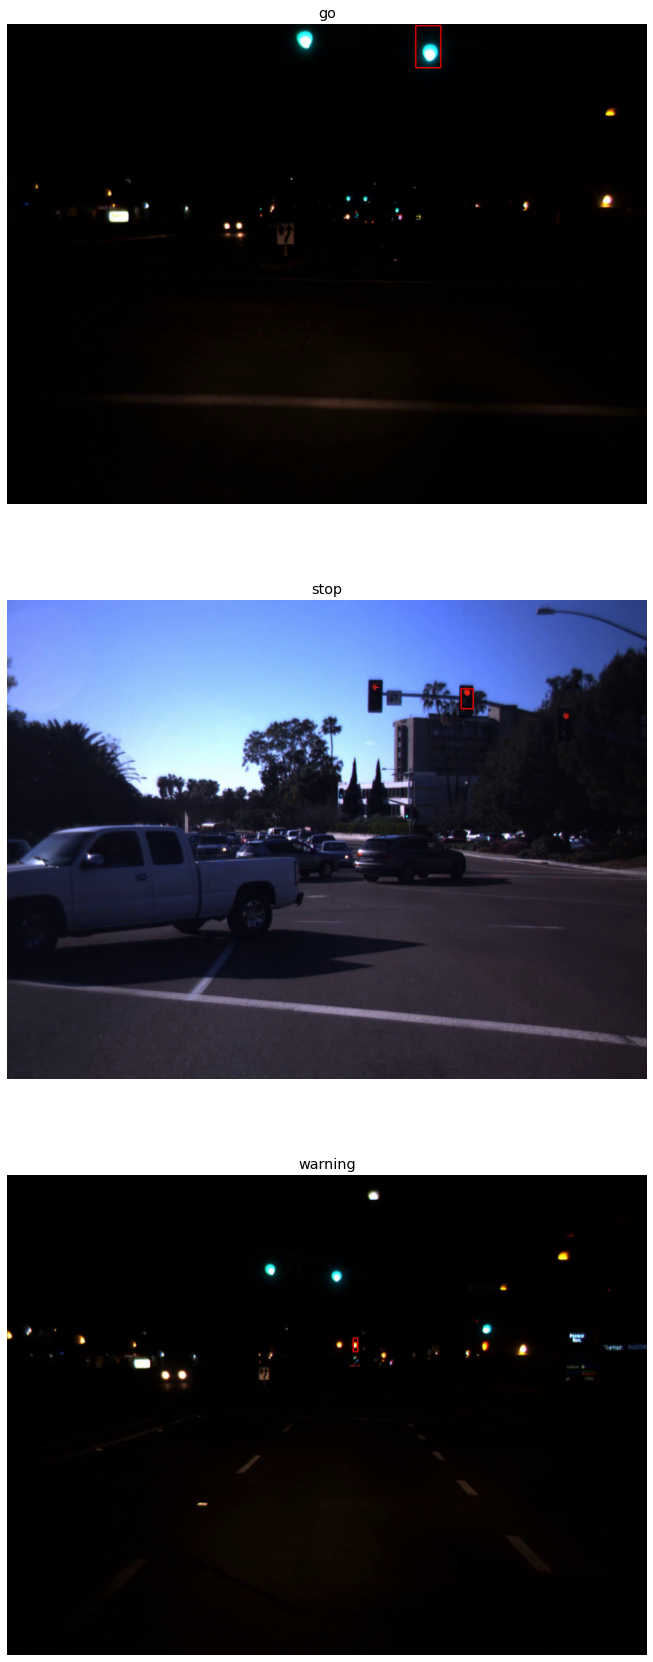

In [ ]:
fig, ax = plt.subplots(len(annotation_tags),1,figsize=(15,10*len(annotation_tags)))

for i, tag in enumerate(annotation_tags):
    sample = df[df['label']==tag].sample(1)
    bbox = sample[['x_min','y_min','x_max','y_max']].values[0]
    
    image = cv2.imread(sample.image_id.values[0])
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    
    cv2.rectangle(image,(bbox[0],bbox[1]),(bbox[2],bbox[3]),(220, 0, 0), 2)
    
    ax[i].set_title(idx_to_label[tag])
    ax[i].set_axis_off()
    ax[i].imshow(image)



### 4. Train-Test-Val split & Albumentation

In [ ]:
def split(df,p=0.25):
    clipNames = sorted(df['clipNames'].unique())

    nightClips = [name for name in clipNames if 'night' in name]
    dayClips = [name for name in clipNames if 'day' in name]

    testNightClipNames = list(np.random.choice(nightClips,int(len(nightClips)*p)))
    testDayClipNames = list(np.random.choice(dayClips,int(len(dayClips)*p)))
    testClipNames = testNightClipNames + testDayClipNames

    trainDayClipNames = list(set(dayClips) - set(testDayClipNames))
    trainNightClipNames = list(set(nightClips) - set(testNightClipNames))
    trainClipNames = trainNightClipNames + trainDayClipNames
    
    train_df = df[df.clipNames.isin(trainClipNames)]
    test_df = df[df.clipNames.isin(testClipNames)]
    
    return train_df, test_df

In [ ]:
train_df, test_df = split(df)

In [ ]:
train_df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame,isNight,clipNames
0,../input/lisa-traffic-light-dataset/dayTrain/d...,1,698,333,710,358,0,0,dayClip1
1,../input/lisa-traffic-light-dataset/dayTrain/d...,1,846,391,858,411,0,0,dayClip1
2,../input/lisa-traffic-light-dataset/dayTrain/d...,1,698,337,710,357,1,0,dayClip1
3,../input/lisa-traffic-light-dataset/dayTrain/d...,1,847,390,859,410,1,0,dayClip1
4,../input/lisa-traffic-light-dataset/dayTrain/d...,1,698,331,710,356,2,0,dayClip1


In [ ]:
test_df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame,isNight,clipNames
0,../input/lisa-traffic-light-dataset/dayTrain/d...,1,271,379,283,399,0,0,dayClip12
1,../input/lisa-traffic-light-dataset/dayTrain/d...,1,610,294,625,314,0,0,dayClip12
2,../input/lisa-traffic-light-dataset/dayTrain/d...,1,774,359,792,394,0,0,dayClip12
3,../input/lisa-traffic-light-dataset/dayTrain/d...,1,266,364,284,404,1,0,dayClip12
4,../input/lisa-traffic-light-dataset/dayTrain/d...,1,609,293,627,313,1,0,dayClip12


In [ ]:
print("Train shape: ",train_df.shape)
print("Test shape: ",test_df.shape)

Train shape:  (47084, 9)
Test shape:  (4742, 9)


In [ ]:
train_df, val_df = split(train_df)
train_df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame,isNight,clipNames
0,../input/lisa-traffic-light-dataset/dayTrain/d...,1,698,333,710,358,0,0,dayClip1
1,../input/lisa-traffic-light-dataset/dayTrain/d...,1,846,391,858,411,0,0,dayClip1
2,../input/lisa-traffic-light-dataset/dayTrain/d...,1,698,337,710,357,1,0,dayClip1
3,../input/lisa-traffic-light-dataset/dayTrain/d...,1,847,390,859,410,1,0,dayClip1
4,../input/lisa-traffic-light-dataset/dayTrain/d...,1,698,331,710,356,2,0,dayClip1


In [ ]:
val_df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame,isNight,clipNames
0,../input/lisa-traffic-light-dataset/dayTrain/d...,1,323,288,335,308,0,0,dayClip10
1,../input/lisa-traffic-light-dataset/dayTrain/d...,1,506,376,518,396,0,0,dayClip10
2,../input/lisa-traffic-light-dataset/dayTrain/d...,1,587,369,599,389,0,0,dayClip10
3,../input/lisa-traffic-light-dataset/dayTrain/d...,3,210,261,222,279,0,0,dayClip10
4,../input/lisa-traffic-light-dataset/dayTrain/d...,1,330,286,342,306,1,0,dayClip10


In [ ]:
print("Train shape: ",train_df.shape)
print("Validation shape: ",val_df.shape)

Train shape:  (37128, 9)
Validation shape:  (9956, 9)


In [ ]:
# Albumentations

def getTrainTransform():
    return A.Compose([
        A.Resize(height=512, width=512, p=1),
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def getValTransform():
    return A.Compose([
        A.Resize(height=512, width=512, p=1),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def getTestTransform():
    return A.Compose([
        A.Resize(height=512, width=512, p=1),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

### 5. Data Loaders

In [ ]:
EPOCHS = 3
BATCH_SIZE = 16

In [ ]:
class TrafficLightsDataset:
    def __init__(self, df, transforms=None):
        super().__init__()

        self.image_ids = df.image_id.unique()
        self.df = df
        self.transforms = transforms
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df.image_id == image_id]

        image = cv2.imread(image_id)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        boxes = records[['x_min','y_min','x_max','y_max']].values
        boxes = torch.as_tensor(boxes,dtype=torch.float32)
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        labels = torch.as_tensor(records.label.values, dtype=torch.int64)
        
        iscrowd = torch.zeros_like(labels, dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
           
            target['boxes'] = torch.as_tensor(sample['bboxes'],dtype=torch.float32)
            target['labels'] = torch.as_tensor(sample['labels'])
            
        return image, target, image_id

In [ ]:
trainDataset = TrafficLightsDataset(train_df,getTrainTransform())
valDataset = TrafficLightsDataset(val_df,getValTransform())
testDataset = TrafficLightsDataset(test_df,getTestTransform())

In [ ]:
trainDataLoader = DataLoader(
    trainDataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

valDataLoader = DataLoader(
    valDataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

testDataLoader = DataLoader(
    testDataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

## 6. Обучение FasterRCNN

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

N_CLASS = 3 

INP_FEATURES = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(INP_FEATURES, N_CLASS)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [ ]:
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.Adam(params)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [ ]:
class LossAverager:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
lossHist = LossAverager()
valLossHist = LossAverager()

for epoch in range(EPOCHS):
    
    start_time = time()
    model.train()
    lossHist.reset()
    
    for images, targets, image_ids in tqdm(trainDataLoader):
        
        images = torch.stack(images).to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        bs = images.shape[0]
        
        loss_dict = model(images, targets)
        
        totalLoss = sum(loss for loss in loss_dict.values())
        lossValue = totalLoss.item()
        
        lossHist.update(lossValue,bs)

        optimizer.zero_grad()
        totalLoss.backward()
        optimizer.step()
    
    if lr_scheduler is not None:
        lr_scheduler.step(totalLoss)

    print(f"[{str(datetime.timedelta(seconds = time() - start_time))[2:7]}]")
    print(f"Epoch {epoch}/{EPOCHS}")
    print(f"Train loss: {lossHist.avg}")
    
    torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')

100%|██████████| 789/789 [29:33<00:00,  2.25s/it]


[29:34]
Epoch 0/3
Train loss: 0.28320376152451093


100%|██████████| 789/789 [29:23<00:00,  2.24s/it]


[29:24]
Epoch 1/3
Train loss: 0.1482893800982055


100%|██████████| 789/789 [29:18<00:00,  2.23s/it]


[29:19]
Epoch 2/3
Train loss: 0.12759879660490178




## 7. Инференс

In [ ]:
model.eval()
images, targets, image_ids = next(iter(testDataLoader))
images = torch.stack(images).to(device)

outputs = model(images)

In [ ]:
def filterBoxes(output,nms_th=0.3,score_threshold=0.5):
    
    boxes = output['boxes']
    scores = output['scores']
    labels = output['labels']
    
    mask = nms(boxes,scores,nms_th)
    
    boxes = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]
    
    boxes = boxes.data.cpu().numpy().astype(np.int32)
    scores = scores.data.cpu().numpy()
    labels = labels.data.cpu().numpy()
    
    mask = scores >= score_threshold
    boxes = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]
    
    return boxes, scores, labels

In [ ]:
def displayPredictions(image_id,output,nms_th=0.3,score_threshold=0.5):
    
    boxes,scores,labels = filterBoxes(output,nms_th,score_threshold)
    
    image = cv2.imread(image_id)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image = cv2.resize(image,(512,512))
    image /= 255.0
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    colors = {1:(0,255,0), 2:(255,255,0), 3:(255,0,0)}
    
    for box,label in zip(boxes,labels):
        image = cv2.rectangle(image,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      colors[label], 2)

    ax.set_axis_off()
    ax.imshow(image)

    plt.show()

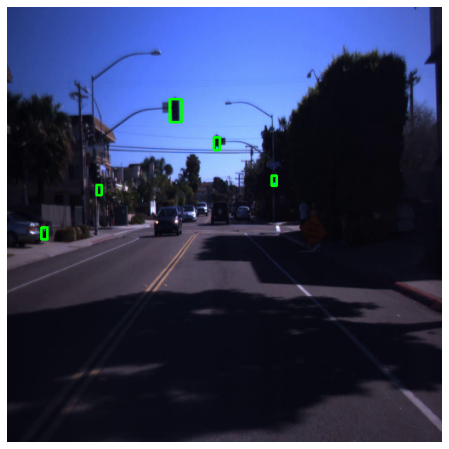

In [ ]:
displayPredictions(image_ids[2],outputs[2],0.2,0.4)

## 8. Итоги

Была создана модель детектирующая светофоры на фотография разной степени освещенности, визуально она работает хорошо. Оценка точности не проводилась.
Модель можно использовать при разработке беспилотного транспорта либо ситсем ассистирования водителю, в дальнейшем планирую добавить детектирование на видео и небольшой веб интерфейс
